Hojas en el Excel: ['2015_16_Districtwise', 'Metadata']
  Field Name                          Description
0     STATCD       Data_Reported_from: State code
1     DISTCD    Data_Reported_from: District Code
2   STATNAME       Data_Reported_from: State name
3   DISTNAME    Data_Reported_from: District name
4  DISTRICTS  Data_Reported_from: No. of district
<class 'pandas.core.series.Series'>
float64


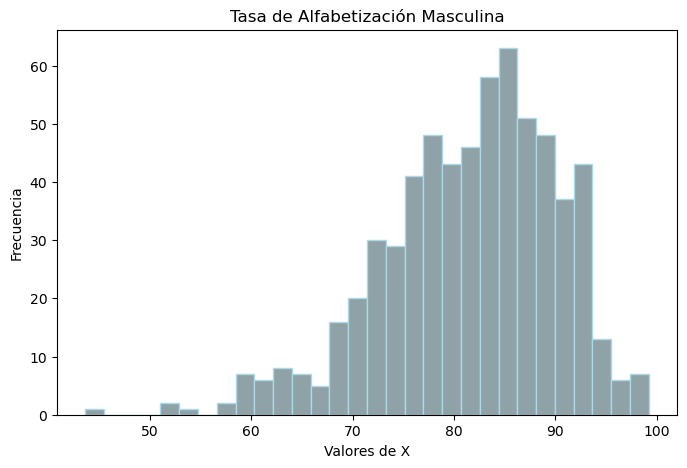

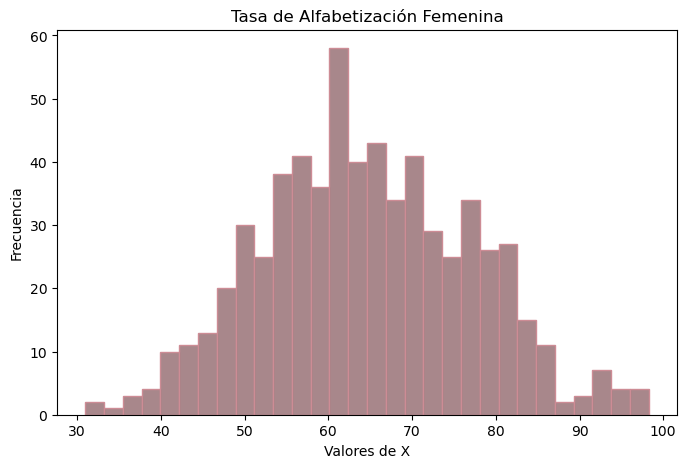

In [1]:
# Primero instala las librerías necesarias (ejecutar en consola/terminal):
# pip install pandas openpyxl matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer todas las hojas de un Excel
excel_path = "C:/Users/VICTOR/Documents/GitHub/Lasso_Potential_Outcomes_RCTs/Python/Input/Districtwise_literacy_rates.xlsx"

# Ver nombres de hojas
sheets = pd.ExcelFile(excel_path).sheet_names
print("Hojas en el Excel:", sheets)

# Leer la hoja "Metadata"
diccionario = pd.read_excel(excel_path, sheet_name="Metadata")
print(diccionario.head())

# Supongamos que tu dataframe principal se llama "data":
data = pd.read_excel(excel_path, sheet_name="2015_16_Districtwise")  

# Revisar tipo de columna
print(type(data["MALE_LIT"]))
print(data["MALE_LIT"].dtype)

# Histograma de alfabetización masculina
plt.figure(figsize=(8,5))
sns.histplot(
    data=data,
    x=pd.to_numeric(data["MALE_LIT"], errors="coerce"),
    bins=30,
    color="#68838B",
    edgecolor="#ADD8E6"
)
plt.title("Tasa de Alfabetización Masculina")
plt.xlabel("Valores de X")
plt.ylabel("Frecuencia")
plt.show()

# Histograma de alfabetización femenina
plt.figure(figsize=(8,5))
sns.histplot(
    data=data,
    x=pd.to_numeric(data["FEMALE_LIT"], errors="coerce"),
    bins=30,
    color="#8B5F65",
    edgecolor="#CD8C95"
)
plt.title("Tasa de Alfabetización Femenina")
plt.xlabel("Valores de X")
plt.ylabel("Frecuencia")
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf

# ======================
# Split Train/Test
# ======================
train_data, test_data = train_test_split(data, test_size=0.25, random_state=123)

# ======================
# Low-dimensional model
# ======================
covariados_low = "P_URB_POP + SEXRATIO + TOTPOPULAT + SCHTOT + OVERALL_LI"
formula_low = f"FEMALE_LIT ~ {covariados_low}"

# Variables relevantes
vars_low = ["FEMALE_LIT", "P_URB_POP", "SEXRATIO", "TOTPOPULAT", "SCHTOT", "OVERALL_LI"]

train_data_low = train_data[vars_low].dropna()
test_data_low = test_data[vars_low].dropna()

# Entrenar modelo OLS
model_low = smf.ols(formula=formula_low, data=train_data_low).fit()

# Predicción en test
Y_test_low = test_data_low["FEMALE_LIT"]
Y_hat_low = model_low.predict(test_data_low)

# Métricas
MSE_low = mean_squared_error(Y_test_low, Y_hat_low)
R2_low = 1 - (MSE_low / np.mean((Y_test_low - np.mean(Y_test_low))**2))

print(f"R-squared out of sample (low-dim): {R2_low:.4f}")

# ======================
# High-dimensional model
# ======================
covariados_high = (
    "I(P_URB_POP**2) + I(SEXRATIO**2) + I(P_SC_POP**2) + I(P_ST_POP**2) "
    "+ I(TOTPOPULAT**2) + I(SCHTOT**2) + I(OVERALL_LI**2) + I(GROWTHRATE**2) "
    "+ (P_URB_POP + SEXRATIO + P_SC_POP + P_ST_POP + TOTPOPULAT + SCHTOT + OVERALL_LI + GROWTHRATE)**2"
)
formula_high = f"FEMALE_LIT ~ {covariados_high}"

# Variables relevantes
vars_high = [
    "FEMALE_LIT", "P_URB_POP", "SEXRATIO", "P_SC_POP", "P_ST_POP",
    "TOTPOPULAT", "SCHTOT", "OVERALL_LI", "GROWTHRATE"
]

train_data_high = train_data[vars_high].dropna()
test_data_high = test_data[vars_high].dropna()

# Entrenar modelo OLS
model_high = smf.ols(formula=formula_high, data=train_data_high).fit()

# Predicción en test
Y_test_high = test_data_high["FEMALE_LIT"]
Y_hat_high = model_high.predict(test_data_high)

# Métricas
MSE_high = mean_squared_error(Y_test_high, Y_hat_high)
R2_high = 1 - (MSE_high / np.mean((Y_test_high - np.mean(Y_test_high))**2))

print(f"R-squared out of sample (high-dim): {R2_high:.4f}")


R-squared out of sample (low-dim): 0.9561
R-squared out of sample (high-dim): 0.9670


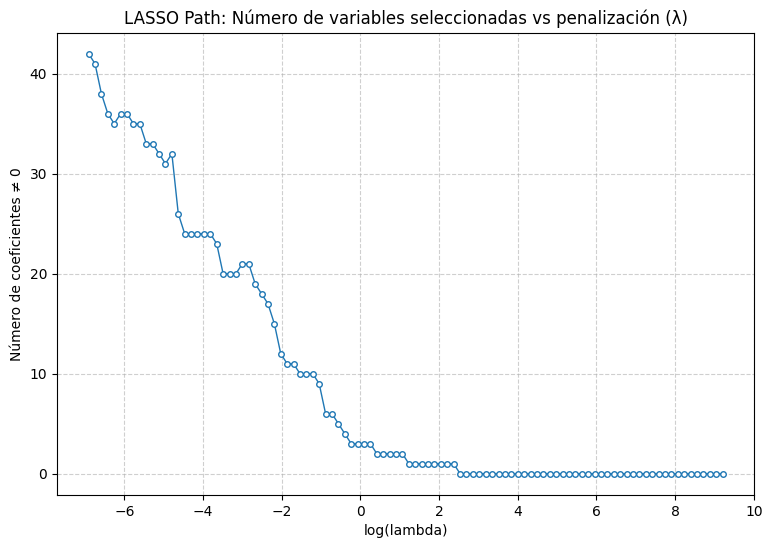

lambda (pequeño) = 0.0010000000000000002 -> num_nonzero = 42
lambda (grande)  = 10000.00000000001 -> num_nonzero = 0


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import lasso_path

# -----------------------
# Ajusta estas variables
# -----------------------
features = [
    "P_URB_POP", "SEXRATIO", "P_SC_POP", "P_ST_POP",
    "TOTPOPULAT", "SCHTOT", "OVERALL_LI", "GROWTHRATE"
]
target = "FEMALE_LIT"

# -----------------------
# 1) Asegurarse de que y no tenga NaN
# -----------------------
train_data_clean = train_data.dropna(subset=[target]).copy()
# (si quieres también limpiar test: test_data = test_data.dropna(subset=[target]))

X_train_raw = train_data_clean[features]
y_train = train_data_clean[target].values

# -----------------------
# 2) Preprocesamiento (fit SOLO en train)
#    imputar -> polinomios -> escalar
# -----------------------
preproc = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

X_train = preproc.fit_transform(X_train_raw)   # matriz lista para LASSO

# -----------------------
# 3) Secuencia de lambdas (igual que en tu R)
# -----------------------
lambda_seq = np.exp(np.linspace(np.log(10000), np.log(0.001), 100))

# -----------------------
# 4) Calcular la trayectoria de LASSO (coeficientes para cada lambda)
# -----------------------
# lasso_path devuelve (alphas, coefs, dual_gaps) con coefs shape = (n_features, n_alphas)
alphas_out, coefs, _ = lasso_path(X_train, y_train, alphas=lambda_seq, max_iter=10000)

# -----------------------
# 5) Contar coeficientes distintos de cero para cada lambda
# -----------------------
threshold = 1e-8
num_nonzero = np.sum(np.abs(coefs) > threshold, axis=0)  # forma (n_alphas,)

# -----------------------
# 6) Ordenar por lambda ascendente para que el eje x aumente left->right
#    (así: a mayor lambda --> menos variables --> pendiente negativa)
# -----------------------
sort_idx = np.argsort(alphas_out)           # alphas_out ascendente
alphas_sorted = alphas_out[sort_idx]
num_nonzero_sorted = num_nonzero[sort_idx]

# -----------------------
# 7) Gráfico final
# -----------------------
plt.figure(figsize=(9,6))
plt.plot(np.log(alphas_sorted), num_nonzero_sorted, '-o', markersize=4, linewidth=1, markerfacecolor="white")
plt.xlabel("log(lambda)")
plt.ylabel("Número de coeficientes ≠ 0")
plt.title("LASSO Path: Número de variables seleccionadas vs penalización (λ)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# -----------------------
# 8) Chequeo rápido (opcional)
# -----------------------
print("lambda (pequeño) =", alphas_sorted[0], "-> num_nonzero =", num_nonzero_sorted[0])
print("lambda (grande)  =", alphas_sorted[-1], "-> num_nonzero =", num_nonzero_sorted[-1])



In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LassoCV

# ================================
# 1. Simulación de datos
# ================================
np.random.seed(123)

# Observaciones
n = 1000

# Covariables
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X3 = np.random.binomial(1, 0.5, n)
X4 = np.random.binomial(1, 0.5, n)

# Tratamiento
D = np.random.binomial(1, 0.5, n)

# Error
e = np.random.normal(0, 1, n)

# Variable dependiente
Y = 2*D + 0.5*X1 - 0.3*X2 + 0.2*X3 + e

# DataFrame
data = pd.DataFrame({"Y": Y, "D": D, "X1": X1, "X2": X2, "X3": X3, "X4": X4})
print(data.head())

# ================================
# 2. Balance check (t-tests)
# ================================
def balance_test(var):
    group0 = data.loc[data["D"] == 0, var]
    group1 = data.loc[data["D"] == 1, var]
    t, p = stats.ttest_ind(group0, group1, equal_var=False)
    return t, p

for var in ["X1", "X2", "X3", "X4"]:
    t, p = balance_test(var)
    print(f"T-test {var}: t={t:.3f}, p={p:.3f}")

# ================================
# 3. Regresión lineal simple: Y ~ D
# ================================
X_simple = sm.add_constant(data["D"])
model_simple = sm.OLS(data["Y"], X_simple).fit()
print(model_simple.summary())

# ================================
# 4. Regresión con controles: Y ~ D + X1 + X2 + X3 + X4
# ================================
X_control = sm.add_constant(data[["D", "X1", "X2", "X3", "X4"]])
model_control = sm.OLS(data["Y"], X_control).fit()
print(model_control.summary())

# ================================
# 5. LASSO (solo covariables, sin D)
# ================================
X_matrix = data[["X1", "X2", "X3", "X4"]].values
Y_vector = data["Y"].values

lasso = LassoCV(cv=5, alphas=np.logspace(3, -3, 100), random_state=123).fit(X_matrix, Y_vector)

lambda_min = lasso.alpha_
print("Lambda óptimo (lambda.min):", lambda_min)

# Coeficientes seleccionados por LASSO
coef_dict = dict(zip(["X1", "X2", "X3", "X4"], lasso.coef_))
print("Coeficientes LASSO:", coef_dict)

# ================================
# 6. Re-estimación con variables seleccionadas
# (en R quedó: Y ~ D + X1 + X2)
# ================================
X_lasso = sm.add_constant(data[["D", "X1", "X2"]])
model_lasso = sm.OLS(data["Y"], X_lasso).fit()
print(model_lasso.summary())


          Y  D        X1        X2  X3  X4
0 -1.395330  0 -1.085631 -0.748827   0   1
1  1.833507  0  0.997345  0.567595   0   1
2  1.059407  1  0.282978  0.718151   1   0
3  1.043562  0 -1.506295 -0.999381   1   1
4  2.854942  1 -0.578600  0.474898   0   1
T-test X1: t=0.597, p=0.550
T-test X2: t=-0.014, p=0.989
T-test X3: t=0.350, p=0.726
T-test X4: t=-1.186, p=0.236
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     823.6
Date:                Tue, 23 Sep 2025   Prob (F-statistic):          1.50e-132
Time:                        21:48:45   Log-Likelihood:                -1524.5
No. Observations:                1000   AIC:                             3053.
Df Residuals:                     998   BIC:                             30